# Trabalho Computacional 3

## Enunciado

### Questão 1 
Estimar a curva de potência de um aerogerador o modelo de regressão polinomial (polyfit, no Matlab/Octave). Para encontrar a ordem adequada do modelo use três critérios:

* O coeficiente de determinação R2; 
* O coeficiente de determinação R2 ajustado; 
* O critério da Informação de Akaike (AIC). Varie k de 1 a 10 e construa os gráficos de cada critério em função da ordem do modelo. Os critérios forneceram resultados iguais para a ordem do modelo polnomial?

### Questão 2
Considere o mesmo problema da questão anterior e a ordem k escolhida para o
modelo polinomial. Em outras palavras, de posse de um conjunto de N pares entradas-saída, assuma que a curva de regressão é um polinômio de ordem k (k >= 0), ou seja
p(v) = a0 + a1.v + a2.v^2 + ... + ak.v^k;
em que v é a velocidade do vento (m/s) e p é a potência gerada (kW) predita pelo modelo
polinomial. Escolha um dos algoritmos de busca aleatória, Global Random Search (GRS) ou
Local Random Search (LRS), para estimar valores para os parâmetros aj , j = 0,...,k. Compare
o resultado obtido com aquele gerado na Questão 1.

### Questão 3
Repita a questão anterior usando as metaheurísticas populacionais PSO ou DE.
Houve melhoria na solução obtida, que justificasse o aumento do custo-computacional?

## Definições Iniciais e Carregamento dos Dados

* Importamos as bibliotecas necessárias e o script pyswarm com as funções para o PSO
* Definimos duas funções objetivos, uma para os algoritmos de busca e outra para o PSO, com uma pequena diferença nos argumentos
* Carregamos os dados em um DataFrame **df**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pyswarm2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [3]:
def FuncObj(W,*args):
    In=args[0].V
    Out=args[0].P
    poly=np.poly1d(W)
    Resid=poly(In)-Out
    return (Resid**2).sum()

In [4]:
def FuncObj2(W,*args):
    In=args[0]
    Out=args[1]
    poly=np.poly1d(W)
    Resid=poly(In)-Out
    return (Resid**2).sum()

In [5]:
df=pd.read_csv('aerogerador.dat',header=None,names=['V','P'],index_col=None,delim_whitespace=True)
print(df.head())

     V  P
0  0.0  0
1  0.0  0
2  0.0  0
3  0.0  0
4  0.0  0


## Regressão Polinomial

O processo é feito seguindo os seguintes passos:

* Realizamos a regressão polinomial, obtendo os pesos da solução
* Criamos um objeto do polinomio com os pesos obtidos no passo 1
* Fazemos a predição a partir dos valores no DataFrame e chamando o objeto criado no passo 2
* Calculamos o R-squared, o R-squared ajustado e o AIC e os adicionamos a lista

In [6]:
rsquared=[]
adjrsquared=[]
aic=[]
lenY=len(df.P)

In [7]:
for k in range(1,11):
    W,residuals,rank,svd,rcond=np.polyfit(x=df.V,y=df.P,deg=k,full=True)
    poly=np.poly1d(W)
    Ypred=poly(df.V)
    r2=r2_score(y_pred=Ypred,y_true=df.P)
    rsquared.append(r2)
    adjrsquared.append(1 - (1-r2)*(lenY-1)/(lenY-rank-1-1))
    aic.append(lenY*np.log(residuals[0]) + 2*(rank-1))

Podemos visualizar os valores de AIC,R-squared e R-squared ajustado pelo grau do polinômio abaixo:

In [8]:
dfStats=pd.DataFrame({'R2':rsquared,'AdjR2':adjrsquared,'AIC':aic},index=range(1,11))
dfStats.index.name='Grau'
print(dfStats)

               AIC     AdjR2        R2
Grau                                  
1     32374.690011  0.929066  0.929160
2     31870.821936  0.943323  0.943424
3     30517.558221  0.968954  0.969023
4     30149.206577  0.973654  0.973724
5     30151.090785  0.973644  0.973726
6     30150.054290  0.973667  0.973761
7     30143.775419  0.973752  0.973857
8     30140.612340  0.973801  0.973917
9     30142.603573  0.973789  0.973917
10    30142.616818  0.973801  0.973940


Olhando o grau do melhor desempenho para cada estatística com o melhor AIC sendo o menor valor, já o melhor R2 e R2-ajustado sendo o maior valor:

In [9]:
bestAIC=dfStats.AIC.idxmin()
bestR2=dfStats.R2.idxmax()
bestAdjR2=dfStats.AdjR2.idxmax()
print('Melhor AIC:'+ str(bestAIC))
print('Melhor R2:'+ str(bestR2))
print('Melhor R2Adj:'+ str(bestAdjR2))

Melhor AIC:8
Melhor R2:10
Melhor R2Adj:8


## Busca Aleatória Global

Fazemos a busca aleatória global, utilizando o limite inferior -10 e o limite superior 10 para os pesos. Utilizamos o grau do polinômio 4 para uma menor complexidade do algoritmo, já que aumentando o grau do polinômio a aproximação para o mínimo se torna muito díficil pela quantidade de parâmetros sendo buscados.

In [10]:
LimInf=-10
LimSup=10
Nitr=5000
Fitness=[]
deg=4

Abaixo temos o algoritmo GRS:

In [11]:
Wbest=np.random.uniform(high=LimSup,low=LimInf,size=deg+1)
for ii in range(0,Nitr):
    Wcand=np.random.uniform(high=LimSup,low=LimInf,size=4+1) #candidato
    if FuncObj(Wcand,df)<FuncObj(Wbest,df):
        Wbest=Wcand
    Fitness.append(FuncObj(Wbest,df))

Podemos visualizar a aptidão ao longo das iterações em escala ln(f):

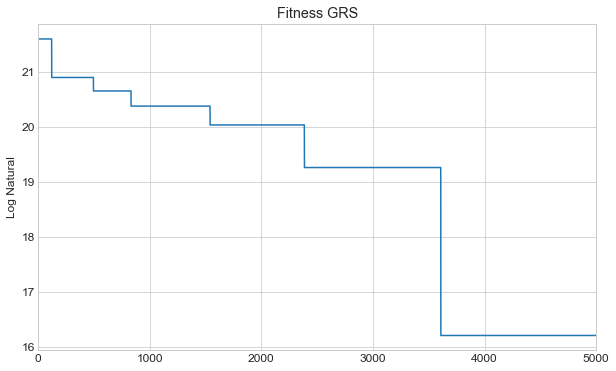

In [12]:
FitnessLog=pd.Series(np.log(Fitness))
sns.set_style('whitegrid')
plt.rc('font',size=12)
FitnessLog.plot(figsize=(10,6),title='Fitness GRS')
plt.ylabel('Log Natural')
plt.show()

In [13]:
FitnessGRS=FitnessLog.values[-1]
print('Aptidão final do GRS:'+str(FitnessGRS))

Aptidão final do GRS:16.2139831184


## Busca Aleatória Local

Realizamos a LRS utilizando os mesmos parâmetros da GRS, mas adicionando o desvio de 0.1:

In [14]:
LimInf=-10
LimSup=10
Nitr=5000
Dev=0.1
Fitness=[]
deg=4

Abaixo temos o algoritmo do LRS:

In [15]:
Wbest=np.random.uniform(high=LimSup,low=LimInf,size=deg+1)
for ii in range(0,Nitr):
    Wcand=np.random.normal(loc=Wbest,scale=Dev) #candidato
    if FuncObj(Wcand,df)<FuncObj(Wbest,df):
        Wbest=Wcand
    Fitness.append(FuncObj(Wbest,df))

Visualizando a aptidão ao longo das iterações:

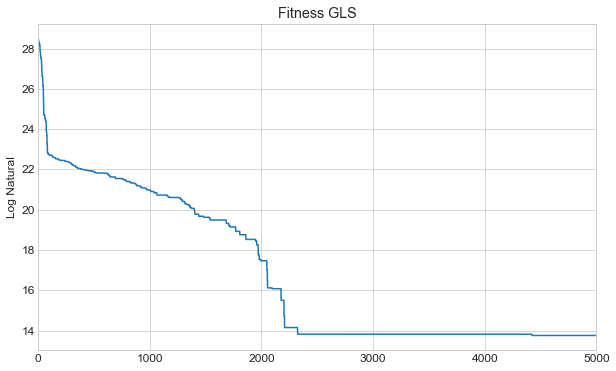

In [16]:
FitnessLog=pd.Series(np.log(Fitness))
plt.rc('font',size=12)
FitnessLog.plot(figsize=(10,6),title='Fitness GLS')
plt.ylabel('Log Natural')
plt.show()

In [18]:
FitnessLRS=FitnessLog.values[-1]
print('Aptidão final do LRS:'+str(FitnessLRS))

Aptidão final do LRS:13.7542284705


## Particle Swarm Optimization

Definimos os parâmetros do PSO, os limites inferiores e superiores dos pesos e máximo de iterações.
Além disso temos os parâmetros do algoritmo abaixo:

* swarmsize - número de partículas: 100
* omega - fator de escala da velocidade da partícula: 0.5
* phip - fator de escala da busca a partir da posição da melhor partícula: 0.5
* phig - fator de escala da busca a partir da melhor posição do enxame: 0.5
* iter_out - inclui o melhor valor da função por iteração

In [19]:
LimInf=[-10, -10, -10, -10, -10]
LimSup=[10, 10, 10, 10, 10]
Nitr=200
xopt,fopt,fiter=pyswarm2.pso(func=FuncObj2,lb=LimInf,ub=LimSup,args=(df.V, df.P),maxiter=Nitr,iter_out=True)

Stopping search: Swarm best position change less than 1e-08


In [20]:
FitnessPSO=np.log(fopt)
print(FitnessPSO)

13.4284381124


Visualizando o fitness da melhor partícula do PSO ao longo das iterações:

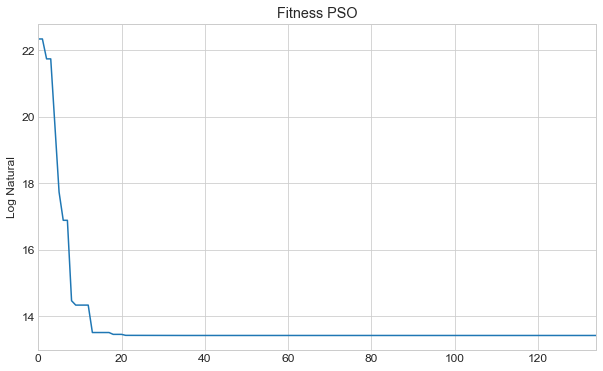

In [21]:
FitnessLog=pd.Series(np.log(fiter))
plt.rc('font',size=12)
FitnessLog.plot(figsize=(10,6),title='Fitness PSO')
plt.ylabel('Log Natural')
plt.show()

## Conclusões Finais

Podemos visualizar as aptidões finais de cada algoritmo e compara-las com a aptidão da regressão polinomial de grau 4.

In [22]:
W,residuals,rank,svd,rcond=np.polyfit(x=df.V,y=df.P,deg=4,full=True)
FitnessPoly=np.log(residuals[0])
fitS=pd.DataFrame([FitnessPoly,FitnessGRS,FitnessLRS,FitnessPSO],index=['Poly','GRS','LRS','PSO'],columns=['Fitness'])
print(fitS)

        Fitness
Poly  13.396092
GRS   16.213983
LRS   13.754228
PSO   13.428438


* Podemos notar que a LRS é bem superior a GRS
* PSO apresenta uma melhoria pequena comparada com o LRS